In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter

# Dataset

In [2]:
df = pd.read_csv("dataset/sbom_list.csv") # general
df_detail = pd.read_csv("dataset/dependency_list.csv")

In [3]:
# The number of unique repositories 
len(pd.unique(df['name']))

652

# Versions and formats

In [4]:
# The number of SPDX and CycloneDX repos
df.groupby('format').count()

,sbom_code,name,URL,path,dependencies,licenses,critical,high,medium,low,quality,version,successfully_processed
format,,,,,,,,,,,,,
JSON,372,372,372,372,371,371,371,371,371,371,371,332,372
SPDX,570,570,570,570,50,50,50,50,50,50,50,570,570
XML,33,33,33,33,33,33,33,33,33,33,33,32,33
YAML,71,71,71,71,71,71,71,71,71,71,71,69,71


In [5]:
# Most common versions for each format
df.groupby('version').format.value_counts()

version  format
0.0.1    JSON      2
0.0.1-1  JSON      1
0.1      XML       5
0.1.31   JSON      1
0.10.0   JSON      1
                  ..
v1.25.0  JSON      1
v1.5.5   JSON      2
v1.8.7   JSON      1
v2.3.0   JSON      1
v3.0.1   JSON      5
Name: count, Length: 206, dtype: int64

# Dependencies

In [6]:
# Dependencies stats
df.dependencies.describe()

count     525.000000
mean       91.342857
std       337.990069
min         0.000000
25%         1.000000
50%         4.000000
75%        37.000000
max      3379.000000
Name: dependencies, dtype: float64

In [7]:
# Dependencies stats per format
df.groupby('format').dependencies.describe()

,count,mean,std,min,25%,50%,75%,max
format,,,,,,,,
JSON,371.0,102.811321,355.867850,0.0,1.5,5.0,43.5,3379.0
SPDX,50.0,18.220000,62.999284,1.0,1.0,1.0,2.0,428.0
XML,33.0,263.484848,585.194739,6.0,39.0,125.0,252.0,3379.0
YAML,71.0,2.901408,2.603047,0.0,1.0,2.0,4.0,11.0


In [8]:
# Project with max number of deps
max = df.dependencies.max()
df[df.dependencies == max].name

17    github.com/Siemens-Healthineers/K2s
18    github.com/Siemens-Healthineers/K2s
Name: name, dtype: object

In [9]:
# Number of projects with no dependencies (it may be good to check why, for example, SBOM declares only License)
len(df[df.dependencies == 0].name)

46

In [10]:
# Empty dependencies for each format. Maybe the fact that there are no deps has something to do with the format rules
df[df.dependencies == 0].groupby('format').size()

format
JSON    38
YAML     8
dtype: int64

In [11]:
# Total dependencies
len(df_detail)

47955

In [12]:
# Unique dependencies
df_detail.name.nunique()

11538

In [13]:
df_detail.groupby("name").size().reset_index(name="count").sort_values(by=["count"], ascending=False).head(100)

,name,count
9992,source,484
10599,typer,125
5159,golang.org/x/sys,104
5496,https,83
3234,debug,75
...,...,...
1943,attrs,31
6049,isarray,31
3939,form-data,31
1736,ansi-escapes,30


In [14]:
# Percentage of empty deps
cdx = df[df.format!="SPDX"]
spx = df[df.format=="SPDX"]

print((len(cdx[cdx.dependencies == 0]) / len(cdx)) * 100)
print((len(spx[spx.dependencies == 0]) / len(spx)) * 100)

9.663865546218489
0.0


In [15]:
# Number of dependencies ecosystems
df_detail["ecosystem"] = df_detail.location.str.extract(r':([^/]+)/')
df_detail.ecosystem.dropna().value_counts()

ecosystem
npm                    21680
maven                   4447
golang                  4390
nix                     3570
cargo                   2402
pypi                    2242
deb                     1816
nuget                   1659
rpm                     1556
swid                    1385
composer                 367
gem                      266
github                   151
container                 90
ACTIONS                   81
https:                    81
apk                       59
hex                       29
NPM                       24
githubactions             21
generic                   20
alpine                    18
RUST                      12
oci                        4
google-code-archive        2
sourceware                 2
cocoapods                  1
Name: count, dtype: int64

In [16]:
# Average number of ecosystem per project
df_detail.dropna(subset=["ecosystem"]).groupby("name")['ecosystem'].nunique().describe()

count    10935.000000
mean         1.029447
std          0.215233
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: ecosystem, dtype: float64

# SBOM quality

In [17]:
# SBOM quality stats
df.quality.describe()

count    525.000000
mean       5.808800
std        2.375265
min        0.000000
25%        5.650000
50%        6.940000
75%        6.960000
max        9.240000
Name: quality, dtype: float64

In [18]:
df.groupby('format').quality.describe()

,count,mean,std,min,25%,50%,75%,max
format,,,,,,,,
JSON,371.0,6.094825,1.915673,0.00,5.65,6.88,7.2000,8.89
SPDX,50.0,2.167000,3.606934,0.00,0.00,0.00,5.5425,9.24
XML,33.0,6.846364,1.226244,4.78,5.60,7.56,7.8000,8.27
YAML,71.0,6.396620,1.508873,0.00,6.96,6.96,6.9600,6.96


In [21]:
# Project(s) with best quality
max = df.quality.max()
df[df.quality == max].name

679    github.com/intel/cve-bin-tool
684    github.com/intel/cve-bin-tool
Name: name, dtype: object

In [22]:
# Project(s) with worst quality
len(df[df.quality == 0].name)

54

# Licenses

In [23]:
# Licenses stats
df.licenses.describe()

count     525.000000
mean       23.765714
std       127.048168
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1606.000000
Name: licenses, dtype: float64

In [24]:
# Licenses per format
df.groupby('format').licenses.describe()

,count,mean,std,min,25%,50%,75%,max
format,,,,,,,,
JSON,371.0,23.633423,142.605050,0.0,0.0,0.0,0.00,1606.0
SPDX,50.0,19.340000,78.045672,0.0,1.0,1.0,2.75,545.0
XML,33.0,82.969697,122.292550,0.0,0.0,39.0,109.00,370.0
YAML,71.0,0.056338,0.333266,0.0,0.0,0.0,0.00,2.0


In [25]:
# Project with max Licenses
max = df.licenses.max()
df[df.licenses==max].name

84    github.com/mchmarny/disco
Name: name, dtype: object

In [26]:
# Projects without licenses
len(df[df.licenses==0])

379

In [27]:
# Difference between formats for repo without licenses 
df[df.licenses==0].groupby('format').size()

format
JSON    293
SPDX      4
XML      13
YAML     69
dtype: int64

In [28]:
# Percentage of no licenses by format
print(len(cdx[cdx.licenses==0])/len(cdx) * 100)
print(len(spx[spx.licenses==0])/len(spx) * 100)

78.78151260504201
0.7017543859649122


In [29]:
# Most common license
licenses = df_detail.licenses.dropna().str.split("|")
all_licenses = [l for sublist in licenses for l in sublist]
df_license_stats = pd.DataFrame(all_licenses, columns=['license'])
license_counts = df_license_stats['license'].value_counts().reset_index()
license_counts.columns = ['license', 'count']
license_counts['percentage'] = (license_counts['count'] / license_counts['count'].sum()) * 100
license_counts.head(10)

,license,count,percentage
0,MIT,3087,24.741524
1,Apache-2.0,1865,14.947503
2,BSD-3-Clause,706,5.658411
3,NONE,432,3.462371
4,GPL-2.0-only,391,3.133766
5,EPL-2.0,371,2.973471
6,GPL-2.0-or-later,331,2.652881
7,ISC,269,2.155967
8,GPL-3.0-or-later,259,2.075820
9,BSD-2-Clause,228,1.827362


In [30]:
# Total different licenses
len(license_counts)

658

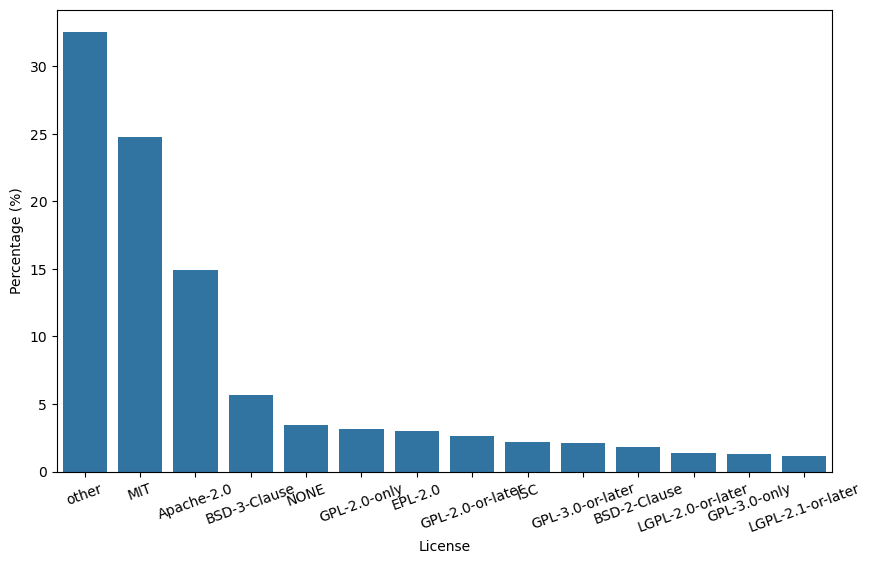

In [32]:
# Aggregate licenses with small percentages into 'other' category
threshold = 1  # percentage threshold to consider as 'other'
license_counts.loc[license_counts['percentage'] < threshold, 'license'] = 'other'

# Recalculate the counts and percentages
aggregated_counts = license_counts.groupby('license').agg({'count': 'sum'}).reset_index()
aggregated_counts['percentage'] = (aggregated_counts['count'] / aggregated_counts['count'].sum()) * 100
aggregated_counts = aggregated_counts.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='license', y='percentage', data=aggregated_counts)
#plt.title('License Percentages (with "other" category)')
plt.xticks(rotation=20)
plt.ylabel('Percentage (%)')
plt.xlabel('License')
plt.show()


# Vulnerabilities

In [33]:
# Fixing the -1 in the CVE columns
cve_cols = ["critical", "high", "medium", "low"]
df[cve_cols] = df[cve_cols].replace(-1, 0)

In [34]:
# Stats an all cve
df["cves_count"] = df[cve_cols].sum(axis=1)

In [35]:
df.cves_count.describe()

count    1046.000000
mean        1.107075
std         6.958249
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       120.000000
Name: cves_count, dtype: float64

In [36]:
df.groupby('format').cves_count.describe()

,count,mean,std,min,25%,50%,75%,max
format,,,,,,,,
JSON,372.0,2.446237,9.418100,0.0,0.0,0.0,1.0,120.0
SPDX,570.0,0.021053,0.307342,0.0,0.0,0.0,0.0,7.0
XML,33.0,7.151515,21.652253,0.0,1.0,2.0,4.0,120.0
YAML,71.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [37]:
# Project with max CVE
max = df.cves_count.max()
df[df.cves_count==max].name

17    github.com/Siemens-Healthineers/K2s
18    github.com/Siemens-Healthineers/K2s
Name: name, dtype: object

In [38]:
# Percentage of repos without CVE
len(df[df.cves_count==0])/len(df) * 100

85.27724665391969

In [39]:
# CVE stats by severity
df[cve_cols].describe()

,critical,high,medium,low
count,525.000000,525.000000,525.000000,525.000000
mean,0.175238,1.045714,0.923810,0.060952
std,0.882266,5.269258,3.784498,0.309054
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,13.000000,72.000000,43.000000,3.000000


In [40]:
df_detail['CVEs'].dropna().str.split("|", expand=True).stack().nunique()

1016

In [41]:
df_detail['CVEs'].dropna().str.split("|", expand=True).stack()

104    0     CVE-2024-2700
171    0    CVE-2024-29025
421    0    CVE-2024-29025
463    0     CVE-2024-2700
541    0     CVE-2024-2700
                 ...      
47946  4    CVE-2023-39325
       5    CVE-2023-44487
       6    CVE-2023-39325
       7    CVE-2023-45288
       8    CVE-2023-45288
Length: 4543, dtype: object

In [45]:
# Split CVEs and Severities
df_severity = df_detail[['CVEs', 'severity']].dropna()
df_severity['CVEs_c'] = df_detail['CVEs'].str.split('|')
df_severity['severity_c'] = df_detail['severity'].str.split('|')

# Initialize a dictionary to count CVEs by severity
severity_counts = {'CRITICAL': Counter(), 'HIGH': Counter(), 'MEDIUM': Counter(), 'LOW': Counter()}

# Iterate through the rows of the DataFrame
for _, row in df_severity.iterrows():
    for cve, severity in zip(row['CVEs_c'], row['severity_c']):
        if severity in severity_counts:
            severity_counts[severity][cve] += 1

# Determine the most occurring CVE for each severity
most_common_cves = {severity: counts.most_common(1)[0] for severity, counts in severity_counts.items() if counts}

# Output the result
most_common_cves

{'CRITICAL': ('CVE-2021-44906', 13),
 'HIGH': ('CVE-2022-27664', 29),
 'MEDIUM': ('CVE-2022-25883', 46),
 'LOW': ('CVE-2021-43307', 9)}

In [46]:
# Most common CVEs
cves = df_detail['CVEs'].dropna().str.split("|")
all_cves = [c for sublist in cves for c in sublist]
df_cves_stats = pd.DataFrame(all_cves, columns=['cves'])
cves_counts = df_cves_stats['cves'].value_counts().reset_index()
cves_counts.columns = ['cves', 'count']
cves_counts['percentage'] = (cves_counts['count'] / cves_counts['count'].sum()) * 100
cves_counts[cves_counts.cves.str.contains('2011')]

,cves,count,percentage
883,CVE-2011-4969,1,0.022012


In [47]:
# Oldest CVE year
cves_counts.cves.str.extract(r'(\d{4})').dropna().min()

0    2011
dtype: object

In [48]:
# Top most occurring CWE
cwes = df_detail['CWEs'].dropna().str.split("|")
all_cwes = [cw for sublist in cwes for cw in sublist]
df_cwes_stats = pd.DataFrame(all_cwes, columns=['cwes'])
cwes_counts = df_cwes_stats['cwes'].value_counts().reset_index()
cwes_counts.columns = ['cwes', 'count']
cwes_counts['percentage'] = (cwes_counts['count'] / cwes_counts['count'].sum()) * 100
cwes_counts.head()

,cwes,count,percentage
0,CWE-400,480,13.208586
1,CWE-20,208,5.723720
2,CWE-1333,190,5.228398
3,CWE-770,142,3.907540
4,CWE-476,131,3.604843


In [49]:
# Stats for CWEs associated to each depedendency
cwes.apply(lambda x: len(x)).describe()

count    1134.000000
mean        3.204586
std        19.017308
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       448.000000
Name: CWEs, dtype: float64

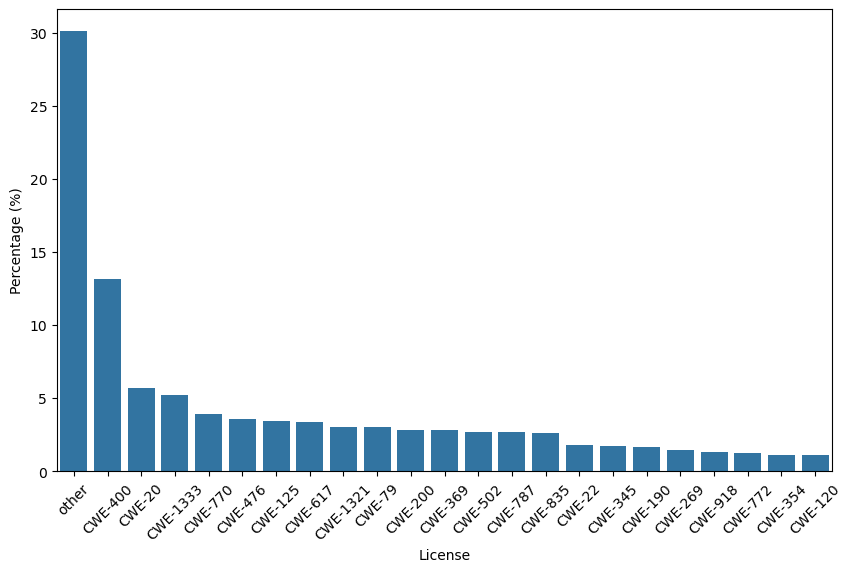

In [50]:
threshold = 1  # percentage threshold to consider as 'other'
cwes_counts.loc[cwes_counts['percentage'] < threshold, 'cwes'] = 'other'
aggregated_counts = cwes_counts.groupby('cwes').agg({'count': 'sum'}).reset_index()
aggregated_counts['percentage'] = (aggregated_counts['count'] / aggregated_counts['count'].sum()) * 100
aggregated_counts = aggregated_counts.sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='cwes', y='percentage', data=aggregated_counts)
#plt.title('License Percentages (with "other" category)')
plt.xticks(rotation=45)
plt.ylabel('Percentage (%)')
plt.xlabel('License')
plt.show()

In [51]:
# CVSS severity occurrencies
df_detail.severity.dropna().str.split("|", expand=True).stack().value_counts()

MEDIUM      1509
HIGH        1127
LOW          308
CRITICAL     106
NONE          57
Name: count, dtype: int64

In [52]:
# CVSS criticality
df_detail.criticality.dropna().str.split("|", expand=True).stack().str.extract(r'CVSS:(\d\.\d)')[0].unique()

array(['3.1', '3.0'], dtype=object)

# Relationship types

In [53]:
# Stats about relationship types for each dependency
df_detail.relationship_types.dropna().str.split("|").apply(lambda x: len(x)).describe()

count    5198.000000
mean       10.471720
std        45.318511
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max      1203.000000
Name: relationship_types, dtype: float64

In [54]:
# Most common relationship types (in %)
df_detail.relationship_types.dropna().str.split("|", expand=True).stack().str.replace("dependsOn", "DEPENDS_ON").value_counts(normalize=True)*100

DEPENDS_ON                57.118974
CONTAINS                  37.577160
DEPENDENCY_OF              3.606335
OTHER                      1.063713
DYNAMIC_LINK               0.420708
BUILD_DEPENDENCY_OF        0.106555
TEST_DEPENDENCY_OF         0.058789
PREREQUISITE_FOR           0.016534
BUILD_TOOL_OF              0.011023
RUNTIME_DEPENDENCY_OF      0.009186
TEST_CASE_OF               0.005511
OPTIONAL_DEPENDENCY_OF     0.003674
OPTIONAL_COMPONENT_OF      0.001837
Name: proportion, dtype: float64

In [85]:
df_detail.relationships.dropna().str.split("|", expand=True).stack().nunique()

21479